In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
from kaggle_secrets import UserSecretsClient
GOOGLE_API_KEY = UserSecretsClient().get_secret("google_api key")
os.environ["google_api key"] = GOOGLE_API_KEY

In [5]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

In [6]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, List, Dict

# Define the state of the conversation
class OrderState(TypedDict):
    messages: List[Dict[str, str]]


# Try using different models. The `pro` models perform the best, especially
# with tool-calling. The `flash` models are super fast, and are a good choice
# if you need to use the higher free-tier quota.
# Check out the features and quota differences here: https://ai.google.dev/pricing
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

graph_builder.add_edge(START, "chatbot")
# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge("chatbot", END)

chat_graph = graph_builder.compile()

Nodes in graph: ['__start__', 'chatbot', '__end__']
Edges in graph: [('__start__', 'chatbot'), ('chatbot', '__end__')]


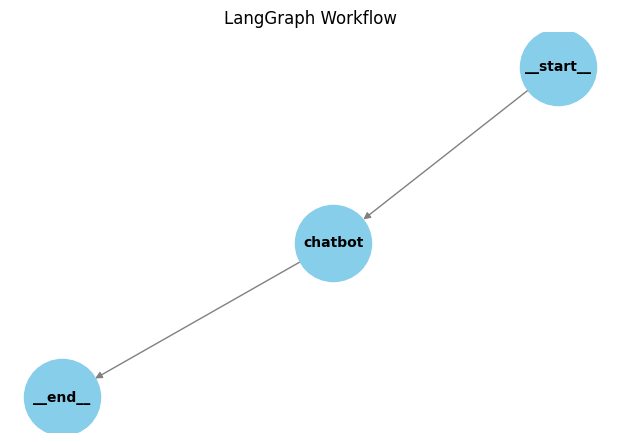

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Manually convert LangGraph into a NetworkX graph
nx_graph = nx.DiGraph()  # Create a directed graph

# Add nodes
for node in chat_graph.get_graph().nodes:
    nx_graph.add_node(node)

# Add edges
for edge in chat_graph.get_graph().edges:
    # Ensure we handle edges correctly, as they might have more data
    source, target = edge[:2]  # Unpack the first two items (source, target)
    nx_graph.add_edge(source, target)

# Print graph structure for debugging
print("Nodes in graph:", list(nx_graph.nodes))
print("Edges in graph:", list(nx_graph.edges))

# Draw the graph using Matplotlib
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(nx_graph, seed=42)  # Consistent layout
nx.draw(nx_graph, pos, with_labels=True, node_color="skyblue", edge_color="gray",
        node_size=3000, font_size=10, font_weight="bold", arrows=True)
plt.title("LangGraph Workflow")
plt.show()

In [12]:

# Running the graph for the first time (single turn)

# Importing pprint for pretty printing
from pprint import pprint  # importing pprint (for displaying full state if needed)

# Writing a user message
user_msg = ("user", "Hi, what drinks do you have?")  # creating a first user message

# Defining the initial state
state = {"messages": [user_msg]}  # setting initial state with the user's message

# Running the graph
state = chat_graph.invoke(state)  # invoking the graph (processing one step)

# Printing messages
for msg in state["messages"]:  # looping through messages (for displaying them)
    print(f"{type(msg).__name__}: {msg.content}")  # printing message type and content

TransportError: Failed to retrieve http://metadata.google.internal/computeMetadata/v1/universe/universe_domain from the Google Compute Engine metadata service. Compute Engine Metadata server unavailable

In [13]:
# Making it handle a second turn manually

# Writing a second user message
user_msg = ("user", "I would like a latte please.")  # creating second user message

# Adding it to the state
state["messages"].append(user_msg)  # appending second user message to the conversation

# Running the graph again
state = chat_graph.invoke(state)  # invoking the graph again (processing next step)

# Printing updated conversation
for msg in state["messages"]:  # looping through messages (for displaying them)
    print(f"{type(msg).__name__}: {msg.content}")  # printing message type and content

TransportError: Failed to retrieve http://metadata.google.internal/computeMetadata/v1/universe/universe_domain from the Google Compute Engine metadata service. Compute Engine Metadata server unavailable